## Reshape des inputs

Imports

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time

Chargement des données

In [8]:
data = pd.read_pickle(r"C:\Users\quent\Documents\IMTA3\PO\V2\Inputs\group5min_inputs.pkl")

Paramètres pour le reshape des inputs

In [9]:
# Paramètre : Regroupement des données pour les input
## A indicer sur les données en sortie de input generation
step_group = "5min"

## A ajuster

# Paramètre : Intervalle de temps pour une ligne d'entrainement
delta_train = "1h"

# Paramètre : intervalle de temps sur lequel on souhaite faire une prédiction à une date donnée
delta_prediction = "5min"

# Paramètre : temps de window slide pour chaque nouvelle inpute
window_slide = "5min"

Indices pour sélection les lignes

In [10]:
index_delta_train = pd.Timedelta(delta_train).seconds // pd.Timedelta(step_group).seconds
index_delta_prediction = pd.Timedelta(delta_prediction).seconds // pd.Timedelta(step_group).seconds
index_window_slide = pd.Timedelta(window_slide).seconds // pd.Timedelta(step_group).seconds

Initialisation des listes vide

In [11]:
X = list()
y = list()

Ajout des variables d'entrainement dans ces listes

In [12]:
start = time.time()

index = 0

while (index + index_delta_train < data.shape[0]) and (index+index_delta_prediction < data.shape[0]):
    index_end = index+index_delta_train
    X.append(list(data.iloc[index:index_end].values))
    y.append(list(data.iloc[index_end:index_end+index_delta_prediction, 1:-(7+12)].sum().values))
    index += index_window_slide
    
print("Temps d'exécution : {:.2} s".format(time.time()-start))

Temps d'exécution : 1.1e+02 s


On passe les variables au format numpy array

In [13]:
X = np.array(X)
y = np.array(y)

Séparation des données entre le training set (90%) et le test set (10%)

In [14]:
# Test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

date_test = X_test[:,:,0].flatten()
X_test = np.delete(X_test, 0, axis=2)


# Train and dev set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=1)

date_train = X_train[:,:,0].flatten()
X_train = np.delete(X_train, 0, axis=2)

date_val = X_val[:,:,0].flatten()
X_val = np.delete(X_val, 0, axis=2)

## Model

Import des librairies

In [15]:
from datetime import datetime

Données d'architecture du LSTM

In [16]:
nb_inputs = X_train.shape[0]
nb_steps = X_train.shape[1]
nb_features = X_train.shape[2]

nb_inputs

80171

## Keras

In [17]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import keras
import keras.backend as K
import tensorflow as tf

from livelossplot import PlotLossesKeras

# Load the TensorBoard notebook extension
%load_ext tensorboard

Using TensorFlow backend.


In [18]:
nb_steps = X_train.shape[1]
nb_features = X_train.shape[2]
nb_hidden_units = 250
batch_size = 256

out_shape = y_train.shape[1]

Metric to evaluate model

In [19]:
def count_by_row(t):
    y, idx, count = tf.unique_with_counts(t)
    return K.sum(count-1)

def metric_top_10(y_true, y_pred):
    _, ind_pred = tf.nn.top_k(y_pred, k=10, sorted=True, name=None)
    _, ind_true = tf.nn.top_k(y_true, k=10, sorted=True, name=None)

    count = tf.map_fn(count_by_row, tf.concat([ind_pred, ind_true], 1))
    return K.mean(count)
    # return tf.round(tf.reduce_mean(count), 3)

In [ ]:
start=time.time()
model = Sequential()

model.add(LSTM(nb_hidden_units, activation='relu', input_shape=(nb_steps, nb_features)))
model.add(Dense(out_shape))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy', metric_top_10])

model.summary()

# Load pre trained weights
#model.load_weights('/tmp/weights.hdf5')

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, verbose=1)

print("\n")
print("Time : {:.2f} s".format(time.time()-start))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 250)               527000    
_________________________________________________________________
dense_1 (Dense)              (None, 257)               64507     
Total params: 591,507
Trainable params: 591,507
Non-trainable params: 0
_________________________________________________________________
Train on 80171 samples, validate on 8908 samples
Epoch 1/10
80171/80171 [==============================] - 161s 2ms/step - loss: 0.9285 - accuracy: 0.3016 - metric_top_10: 4.0168 - val_loss: 0.8881 - val_accuracy: 0.3143 - val_metric_top_10: 3.8387
Epoch 2/10
80171/80171 [==============================] - 163s 2ms/step - loss: 0.8514 - accuracy: 0.3218 - metric_top_10: 3.9697 - val_loss: 0.8730 - val_accuracy: 0.3249 - val_metric_top_10: 4.2043
Epoch 3/10
80171/80171 [==============================] - 166

Sauvegarde des poids

In [ ]:
model.save_weights(filepath="weights/inputs_{}_DT_{}_DP_{}_WS_{}_hidden_{}.hdf5".format(step_group,delta_train,delta_prediction,window_slide,nb_hidden_units))

Tensorboard

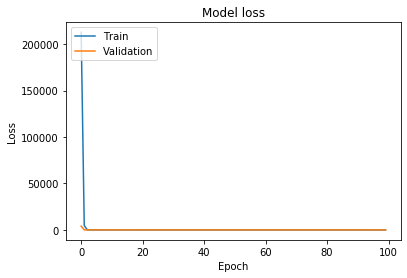

In [15]:

import matplotlib.pyplot as plt
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

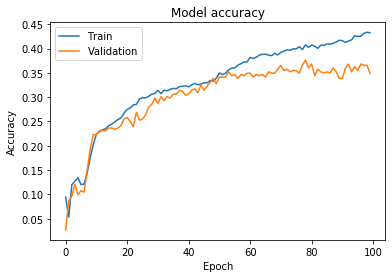

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Validate on test set

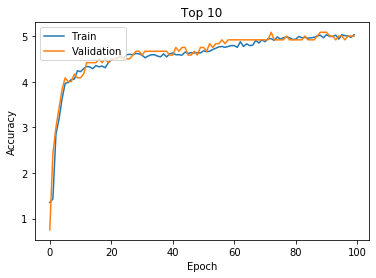

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['metric_top_10'])
plt.plot(history.history['val_metric_top_10'])
plt.title('Top 10')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



In [20]:
print(history)

In [58]:
time.date()

AttributeError: module 'time' has no attribute 'date'

In [69]:
print(datetime.now())

2020-01-22 10:17:58.499941
